In [6]:
import os

root_folder = "/content/drive/MyDrive/CVPR"

# Check existence
print("Root exists:", os.path.isdir(root_folder))

print("\n--- Top-level contents ---")

# Scan first level
top_items = sorted(os.listdir(root_folder))
for entry in top_items:
    full = os.path.join(root_folder, entry)
    entry_type = "DIR " if os.path.isdir(full) else "FILE"
    print(f"{entry_type} - {entry}")

print("\n--- One-level-deep preview ---")

# Scan inside each folder
for entry in top_items:
    folder_path = os.path.join(root_folder, entry)

    if not os.path.isdir(folder_path):
        continue

    inner_items = sorted(os.listdir(folder_path))
    print(f"\n[{entry}] -> {len(inner_items)} items")

    # show items
    for obj in inner_items[:30]:
        obj_path = os.path.join(folder_path, obj)
        obj_type = "DIR " if os.path.isdir(obj_path) else "FILE"
        print(f"   {obj_type} - {obj}")

    if len(inner_items) > 30:
        print("   ...")


Root exists: True

--- Top-level contents ---
DIR  - animal_dataset
DIR  - animal_dataset_split

--- One-level-deep preview ---

[animal_dataset] -> 3 items
   DIR  - cat
   DIR  - dog
   DIR  - panda

[animal_dataset_split] -> 3 items
   DIR  - test
   DIR  - train
   DIR  - val


In [7]:
import os

# Main dataset directory
root_dir = "/content/drive/MyDrive/CVPR/animal_dataset"

# Expected folders (class names)
labels = ["cat", "dog", "panda"]

# Accepted image file extensions
valid_ext = (".jpg", ".jpeg", ".png", ".bmp")

image_list = []

print("Counting images...\n")

for label in labels:
    class_dir = os.path.join(root_dir, label)

    if not os.path.isdir(class_dir):
        print(f"[WARNING] Missing folder: {class_dir}")
        continue

    # filter only valid image files
    imgs = [name for name in os.listdir(class_dir)
            if name.lower().endswith(valid_ext)]

    print(f"{label}: {len(imgs)} images")

    for img in imgs:
        image_list.append((os.path.join(class_dir, img), label))

print("\nTOTAL IMAGES FOUND:", len(image_list))


Counting images...

cat: 100 images
dog: 100 images
panda: 100 images

TOTAL IMAGES FOUND: 300


Image counts per class:
  cat: 100 images
  dog: 100 images
  panda: 100 images

Image Data shape: (300, 1024)
Labels shape: (300,)


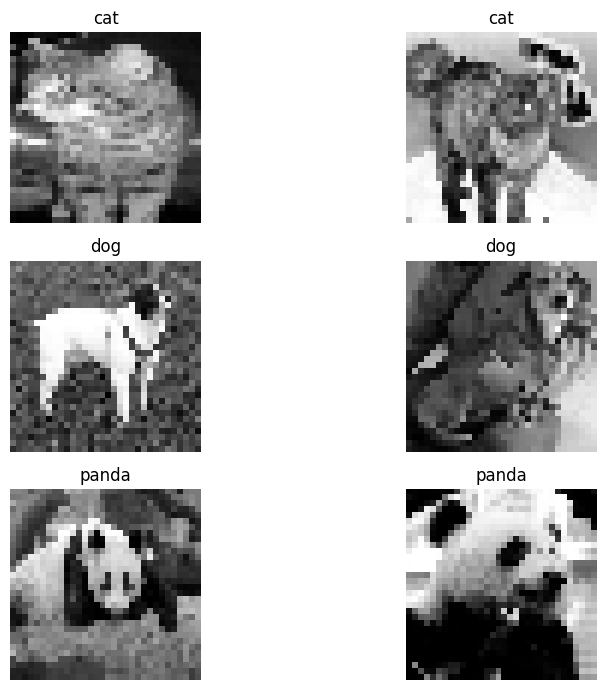

In [8]:
# ======================================
# Dataset Loading and Preprocessing
# ======================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Class folders
paths = {
    "cat":   "/content/drive/MyDrive/CVPR/animal_dataset/cat",
    "dog":   "/content/drive/MyDrive/CVPR/animal_dataset/dog",
    "panda": "/content/drive/MyDrive/CVPR/animal_dataset/panda"
}

class_names = list(paths.keys())
img_size = (32, 32)

def prepare_dataset(folder_map, img_size):
    X, y = [], []

    for cls_name, folder in folder_map.items():
        if not os.path.isdir(folder):
            print(f"[Missing] {folder}")
            continue

        label = class_names.index(cls_name)
        all_files = os.listdir(folder)

        for f in all_files:
            if not f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                continue

            fpath = os.path.join(folder, f)
            img = cv2.imread(fpath)

            if img is None:
                continue

            # convert → grayscale → resize
            g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            g = cv2.resize(g, img_size)

            X.append(g.flatten().astype("float32"))
            y.append(label)

    X = np.array(X) / 255.0
    y = np.array(y, dtype=np.int64)
    return X, y


# Load images
data, labels = prepare_dataset(paths, img_size)

# Display counts
print("Image counts per class:")
for idx, name in enumerate(class_names):
    print(f"  {name}: {np.sum(labels == idx)} images")

print("\nImage Data shape:", data.shape)
print("Labels shape:", labels.shape)

# ======================================
# Quick Visualization
# ======================================
samples_to_show = 2
plt.figure(figsize=(10, 7))
slot = 1

for lbl, cls_name in enumerate(class_names):
    inds = np.where(labels == lbl)[0]
    chosen = np.random.choice(inds, samples_to_show, replace=False)

    for i in chosen:
        img = (data[i].reshape(img_size) * 255).astype(np.uint8)
        plt.subplot(len(class_names), samples_to_show, slot)
        plt.imshow(img, cmap="gray")
        plt.title(cls_name)
        plt.axis("off")
        slot += 1

plt.tight_layout()
plt.show()


In [9]:
import numpy as np

def l1_distance(x, X):
    """Compute L1 (Manhattan) distance between query x and dataset X."""
    return np.sum(np.abs(X - x), axis=1)

def l2_distance(x, X):
    """Compute L2 (Euclidean) distance between query x and dataset X."""
    return np.sqrt(np.sum((X - x) ** 2), axis=1)

def knn_predict(X_train, y_train, x_query, k=5, metric="L2"):
    """
    Predict class of a query point using k-NN.
    Supports L1 and L2 distance.
    """

    metric = metric.upper()

    if metric == "L1":
        distances = l1_distance(x_query, X_train)
    elif metric == "L2":
        distances = l2_distance(x_query, X_train)
    else:
        print(f"[WARNING] Unknown metric '{metric}', using L2 by default.")
        distances = l2_distance(x_query, X_train)

    # Get k smallest distances
    k_indices = np.argsort(distances)[:k]
    k_labels = y_train[k_indices]

    # Majority voting
    values, counts = np.unique(k_labels, return_counts=True)
    predicted_label = values[np.argmax(counts)]

    return predicted_label


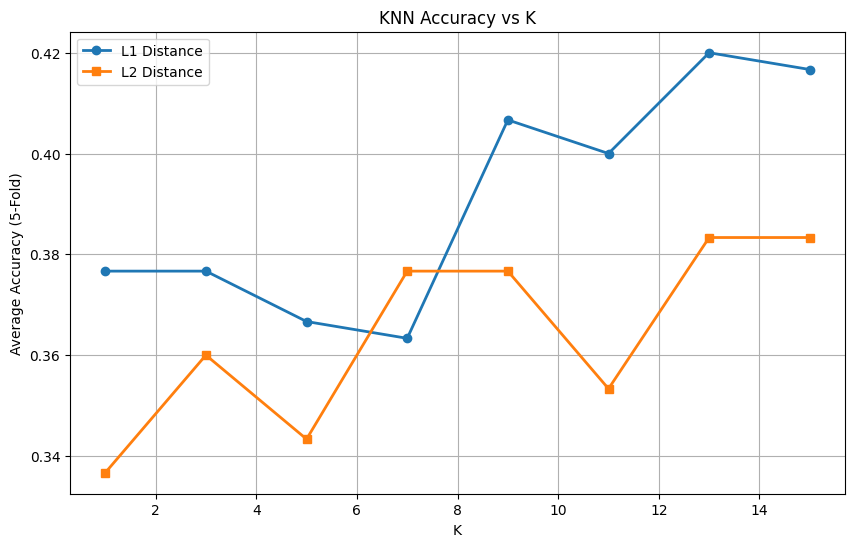

Best L1 → K = 13, Accuracy = 0.4200
Best L2 → K = 13, Accuracy = 0.3833

Best choice → K = 13, Distance = L1 (Manhattan), Accuracy = 0.4200


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ===========================
# Distance Functions
# ===========================

def l1_distance(x, X):
    """Vectorized L1 distance"""
    return np.sum(np.abs(X - x), axis=1)

def l2_distance(x, X):
    """Vectorized L2 distance"""
    return np.sqrt(np.sum((X - x) ** 2, axis=1))  # axis inside np.sum, not np.sqrt


# ===========================
# KNN Classifier
# ===========================

def knn_predict(X_train, y_train, x_query, k, distance_func):
    """Predict class of a single query point"""
    distances = distance_func(x_query, X_train)
    nearest_idx = np.argsort(distances)[:k]
    nearest_labels = y_train[nearest_idx]
    return np.bincount(nearest_labels).argmax()


# ===========================
# Cross-Validation
# ===========================

def cross_validate(data, labels, k_values, distance_func, folds=5):
    n = len(data)
    indices = np.arange(n)
    np.random.shuffle(indices)
    fold_indices = np.array_split(indices, folds)

    results = {k: [] for k in k_values}

    for fold in range(folds):
        test_idx = fold_indices[fold]
        train_idx = np.hstack([fold_indices[i] for i in range(folds) if i != fold])

        X_train, y_train = data[train_idx], labels[train_idx]
        X_test, y_test = data[test_idx], labels[test_idx]

        for k in k_values:
            correct = 0
            for x, y_true in zip(X_test, y_test):
                pred = knn_predict(X_train, y_train, x, k, distance_func)
                correct += (pred == y_true)
            results[k].append(correct / len(y_test))

    # Average accuracy
    avg_accuracy = {k: np.mean(results[k]) for k in k_values}
    return avg_accuracy


# ===========================
# Run Cross-Validation
# ===========================

k_values = [1, 3, 5, 7, 9, 11, 13, 15]
folds = 5

acc_l1 = cross_validate(data, labels, k_values, l1_distance, folds)
acc_l2 = cross_validate(data, labels, k_values, l2_distance, folds)

# ===========================
# Plot Results
# ===========================

plt.figure(figsize=(10, 6))
plt.plot(k_values, [acc_l1[k] for k in k_values], marker="o", label="L1 Distance", linewidth=2)
plt.plot(k_values, [acc_l2[k] for k in k_values], marker="s", label="L2 Distance", linewidth=2)
plt.xlabel("K")
plt.ylabel("Average Accuracy (5-Fold)")
plt.title("KNN Accuracy vs K")
plt.grid(True)
plt.legend()
plt.show()

# ===========================
# Best K & Metric
# ===========================

best_k_l1 = max(acc_l1, key=acc_l1.get)
best_k_l2 = max(acc_l2, key=acc_l2.get)

print(f"Best L1 → K = {best_k_l1}, Accuracy = {acc_l1[best_k_l1]:.4f}")
print(f"Best L2 → K = {best_k_l2}, Accuracy = {acc_l2[best_k_l2]:.4f}")

if acc_l1[best_k_l1] >= acc_l2[best_k_l2]:
    best_k = best_k_l1
    best_metric = "L1 (Manhattan)"
    best_acc = acc_l1[best_k_l1]
else:
    best_k = best_k_l2
    best_metric = "L2 (Euclidean)"
    best_acc = acc_l2[best_k_l2]

print(f"\nBest choice → K = {best_k}, Distance = {best_metric}, Accuracy = {best_acc:.4f}")


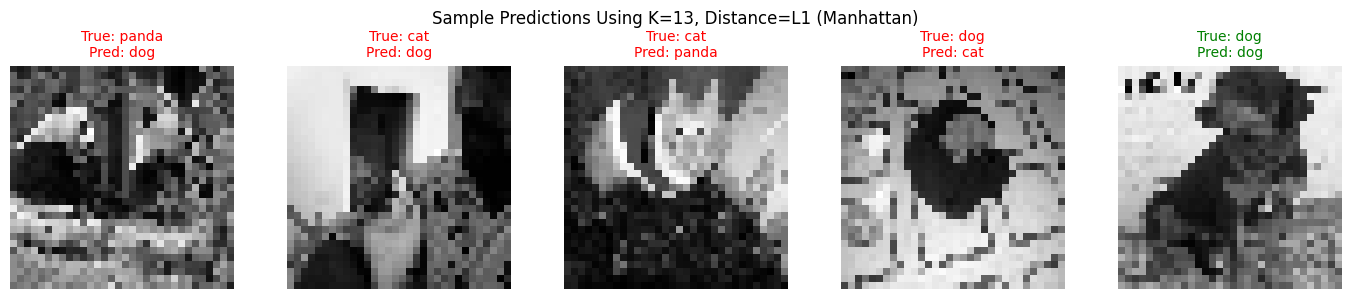

Total samples shown: 5
Correct predictions: 1
Accuracy on shown samples: 20.00%


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# Ensure these variables are defined
# ---------------------------
# image_size used for reshaping flattened images
image_size = (32, 32)

# class names (same as dataset classes)
classes = ["cat", "dog", "panda"]

# choose distance function based on best metric
dist_func = l1_distance if best_metric.startswith("L1") else l2_distance

# ---------------------------
# Prepare one fold for demonstration (fold 0)
# ---------------------------
folds = 5
n_samples = len(data)
indices = np.arange(n_samples)
np.random.shuffle(indices)
fold_indices = np.array_split(indices, folds)

fold = 0
test_idx = fold_indices[fold]
train_idx = np.hstack([fold_indices[i] for i in range(folds) if i != fold])

X_train, y_train = data[train_idx], labels[train_idx]
X_test, y_test = data[test_idx], labels[test_idx]

# Randomly select 5 test samples
num_show = 5
chosen_samples = np.random.choice(len(X_test), num_show, replace=False)

plt.figure(figsize=(14, 3))
correct_count = 0

for i, idx in enumerate(chosen_samples, start=1):
    x_sample = X_test[idx]
    y_true = y_test[idx]
    y_pred = knn_predict(X_train, y_train, x_sample, best_k, dist_func)

    # Determine color: green = correct, red = wrong
    title_color = "green" if y_pred == y_true else "red"
    correct_count += int(y_pred == y_true)

    # Reshape and show image
    img = (x_sample.reshape(image_size) * 255).astype(np.uint8)
    plt.subplot(1, num_show, i)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {classes[y_true]}\nPred: {classes[y_pred]}", fontsize=10, color=title_color)
    plt.axis("off")

plt.suptitle(f"Sample Predictions Using K={best_k}, Distance={best_metric}", fontsize=12)
plt.tight_layout()
plt.show()

# ---------------------------
# Summary
# ---------------------------
print(f"Total samples shown: {num_show}")
print(f"Correct predictions: {correct_count}")
print(f"Accuracy on shown samples: {correct_count / num_show * 100:.2f}%")
